In [1]:
import pandas as pd
import numpy as np
import glob
from tqdm.notebook import tqdm

OPENALEX = '/scratch/fl1092/OpenAlex/openalex'

def printShape(df, cols=[], msg=''):
    
    print(df.shape, end='  ')
    for col in cols:
        print(col, df[col].nunique(), end='  ')
    print(msg)
    
    return df

OPENALEX = '/scratch/fl1092/OpenAlex/openalex'
DIR = '../data/study_2_data'
LARGEFILE = '../data/large'
SCISCINET = '/scratch/fl1092/SciSciNet'

PaperIDtoInt = lambda x: int(x.replace('https://openalex.org/W', ''))

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib

CM = 1/2.54  # centimeters in inches
font = {'size': 7}
matplotlib.rc('font', **font)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

## Data

In [3]:
%%time
paperJournal = (
    pd.read_csv(f'{LARGEFILE}/PaperJournal.csv', usecols=['PaperID','JournalID'])
    .drop_duplicates(subset=['PaperID'])
    .pipe(printShape) # 208261724
)

(208261724, 2)  
CPU times: user 1min 45s, sys: 4.07 s, total: 1min 49s
Wall time: 3min 40s


In [4]:
%%time
paperYear = (
    pd.read_csv(f'{LARGEFILE}/PaperYear.csv', usecols=['PaperID','Year'])
    .pipe(printShape) # 257748845
)

(257748845, 2)  
CPU times: user 37.2 s, sys: 2.33 s, total: 39.5 s
Wall time: 1min 19s


### Region of papers

In [5]:
%%time
authorCount = pd.read_csv(f'{LARGEFILE}/PaperAuthorCount.csv').pipe(printShape) # 235722554

(235722554, 2)  
CPU times: user 30.9 s, sys: 2.22 s, total: 33.1 s
Wall time: 1min 7s


In [22]:
%%time
paperSubRegion = (
    pd.read_csv(f'{LARGEFILE}/PaperSubRegion.csv')
    .merge(authorCount.rename(columns={'AuthorCount':'Total'}), on='PaperID')
    .assign(Percentage=lambda df: df.Count/df.Total)
    
    .query('Percentage > 0.5')
    .drop_duplicates(subset=['PaperID'], keep=False).pipe(printShape, cols=['PaperID'])
    .drop(['Count','Total','Percentage'], axis=1)
) # 87508681

(87508681, 5)  PaperID 87508681  
CPU times: user 1min 34s, sys: 5.69 s, total: 1min 39s
Wall time: 1min 40s


### Whether the paper itself is OA

In [24]:
%%time
worksOA = (
    pd.read_csv(
        f'{OPENALEX}/raw_data/works_open_access.csv.gz',
        usecols=['work_id','is_oa']
    )
    .assign(PaperID=lambda df: df.work_id.apply(PaperIDtoInt))
    .drop(['work_id'], axis=1)
    .pipe(printShape) # 257748845
)

(257748845, 2)  
CPU times: user 8min 34s, sys: 11.9 s, total: 8min 46s
Wall time: 8min 51s


### Percentage of citations that goes to OA papers

In [8]:
%%time
paperOACount = (
    pd.read_csv(f'{LARGEFILE}/PaperCitingOACount.csv')
    .query('is_oa==True')
    .drop(['is_oa'], axis=1)
    .rename(columns={'CitingPaperID':'PaperID'})

    .groupby('PaperID')['count'].sum().reset_index()
    .pipe(printShape, cols=['PaperID'])
) # 71458673

(71458673, 2)  PaperID 71458673  
CPU times: user 1min 30s, sys: 4.3 s, total: 1min 34s
Wall time: 3min 14s


In [9]:
%%time
totalRef = pd.read_csv(f'{LARGEFILE}/PaperReferencesCount.csv').pipe(printShape) # 87419190

(87419190, 2)  
CPU times: user 11.8 s, sys: 866 ms, total: 12.7 s
Wall time: 25.4 s


In [10]:
%%time
paperPaywalledPercent = (
    paperOACount
    .merge(totalRef, on='PaperID', how='right')
    .fillna({'count': 0})
    .assign(Percent=lambda df: 1- (df['count'] / df.ReferencesCount)) # "count" is number of references that goes to OA papers

    .merge(paperJournal, on='PaperID')
    .assign(Percent_within=lambda df: df.groupby('JournalID')['Percent'].transform(lambda x: x - np.mean(x)))
    .pipe(printShape)

    .drop(['JournalID'], axis=1)
)
# 78821844

(78821844, 6)  
CPU times: user 2min 51s, sys: 11.8 s, total: 3min 2s
Wall time: 5min 39s


In [11]:
del paperOACount
del totalRef

### Paper relative citation count, disruptiveness and novelty

In [ ]:
%%time
citationCount = (
    pd.read_csv(f'{LARGEFILE}/RelativeCitationCount.csv',
                usecols=['PaperID','Year','JournalID','cited_by_count'])
    .drop_duplicates(subset=['PaperID'])
    .query('Year <= 2020')

    .assign(
        CitationCount_within=
        lambda df: df.groupby('JournalID')['cited_by_count'].transform(lambda x: x - np.mean(x))
    )
    .pipe(printShape)
    
    .assign(IsCited=lambda df: df.cited_by_count > 0)
) 

In [ ]:
%%time
logCitationCount = (
    citationCount
    
    .query('cited_by_count > 0')
    .drop_duplicates(subset=['PaperID'])
    
    .query('Year <= 2020')
    
    .assign(cited_by_count_log=lambda df: df.cited_by_count.apply(np.log))
    .assign(
        CitationCount_log_within=lambda df:
        df.groupby('JournalID')['cited_by_count_log'].transform(lambda x: x - np.mean(x))
    )
    .pipe(printShape)
)

In [ ]:
%%time
novelty = (
    pd.read_csv(
        f'{SCISCINET}/SciSciNet_Papers.tsv', sep='\t',
        usecols=['PaperID','Disruption','Atyp_10pct_Z']
    )
    .merge(paperJournal, on='PaperID')
    .merge(paperYear, on='PaperID')
    .query('Year <= 2020')
    .pipe(printShape) # 110524459
)

### Paper team size

In [14]:
%%time
authorCount = (
    pd.read_csv(f'{LARGEFILE}/PaperAuthorCount.csv')
    .rename(columns={'Count': 'AuthorCount'})
    .pipe(printShape) # 235722554
)

(235722554, 2)  
CPU times: user 31.4 s, sys: 3.14 s, total: 34.6 s
Wall time: 35.8 s


### Other paper controls

In [38]:
%%time
paperMaxHindex = pd.read_csv(f'{LARGEFILE}/paper_AuthorMaxHIndex.csv')
paperFirstAuthorHindex=pd.read_csv(f'{LARGEFILE}/paper_FirstAuthorHIndex.csv')

In [46]:
%%time
papFirstAuthorAge = pd.read_csv(f'{LARGEFILE}/PaperFirstAuthorAge.csv').pipe(printShape) # 235722554

(235722554, 2)  
CPU times: user 32.9 s, sys: 2.43 s, total: 35.3 s
Wall time: 36.6 s


In [47]:
%%time
papAuthorMaxAge = pd.read_csv(f'{LARGEFILE}/PaperMaxAuthorAge.csv').pipe(printShape)

(235722554, 2)  
CPU times: user 32.6 s, sys: 2.41 s, total: 35 s
Wall time: 37.3 s


In [48]:
%%time
paperCountry = (
    pd.read_csv(f'{LARGEFILE}/PaperCountry.csv')
    .merge(authorCount.rename(columns={'AuthorCount':'Total'}), on='PaperID')
    
    .assign(Percentage=lambda df: df.AuthorCount/df.Total)
    .query('Percentage > 0.5')
    .drop_duplicates(subset=['PaperID'], keep=False).pipe(printShape)
    .drop(['AuthorCount','Total','Percentage'], axis=1)
) # 87114575

(87114575, 5)  
CPU times: user 1min 12s, sys: 7.62 s, total: 1min 20s
Wall time: 1min 22s


In [45]:
%%time
def getCountryControl(row):
    if not pd.isna(row['CountryControl']):
        return row['CountryControl']
    
    elif not pd.isna(row['ProcessedSubRegion']):
        return row['ProcessedSubRegion']
    
    else:
        return 'Unknown'


top20Countries = (
    paperCountry.country_code.value_counts().head(20).reset_index()[['country_code']]
    .assign(CountryControl=lambda df: df.country_code)
)

paperCountryControl = (
    paperCountry.merge(top20Countries, on='country_code', how='left')
    .merge(paperSubRegion, on='PaperID', how='left')
    
    .assign(CountryControl=lambda df: df.apply(getCountryControl, axis=1))
)

CPU times: user 12min 55s, sys: 11.8 s, total: 13min 7s
Wall time: 13min 18s


In [49]:
def collectControls(df):
    
    return (
        df.pipe(printShape)
    
        .merge(paperPaywalledPercent, on='PaperID')
        .query('ReferencesCount >= 10')

        .merge(worksOA, on='PaperID').
        .merge(authorCount, on='PaperID')

        .merge(paperCountryControl, on='PaperID', how='left')

        .merge(paperMaxHindex, on='PaperID', how='left')
        .merge(paperFirstAuthorHindex, on='PaperID', how='left')
        .fillna({'CountryControl':'Other', 'AuthorMaxH_Index':0, 'FirstAuthorH_Index': 0})
        
        .merge(papFirstAuthorAge, on='PaperID')
        .merge(papAuthorMaxAge, on='PaperID')
        .pipe(printShape)
    )

In [ ]:
%%time
toRegress = collectControls(citationCount)

In [ ]:
%%time
toRegressLog = (
    logCitationCount.pipe(printShape)
    .drop(['Year'], axis=1)
    
    .merge(toRegress, on='PaperID')
    .pipe(printShape)
)

In [ ]:
%%time
noveltyToRegress = collectControls(
    novelty[['PaperID','Atyp_10pct_Z','JournalID','Year']].dropna()
    .assign(Novelty_within=lambda df: df.groupby('JournalID')['Atyp_10pct_Z'].transform(lambda x: x - np.mean(x)))
)

In [ ]:
%%time
disruptionToRegress = collectControls(
    novelty[['PaperID','Disruption','JournalID','Year']].dropna()
    .assign(Disruption_within=lambda df: df.groupby('JournalID')['Disruption'].transform(lambda x: x - np.mean(x)))
)

### GVIF

In [56]:
import numpy as np
import pandas as pd

def generalized_VIF(df):
    '''
    Calculates the Generalized VIF (GVIF, Fox and Monette 1992) for a data set. GVIF ** (1 / (2 * Df)) ** 2 < 5 is equivalent to VIF.
    The function assumes that categorical data are typed as 'category' or 'object' and automatically performs one-hot encoding. The function
    will work properly if the data frame has columns previously one-hot encoded from binary data, but it will not work properly if the data 
    frame has multi-nomial columns that have been previously one-hot encoded.

    Args:
        df (pandas data frame): Data frame with the response column(s) removed

    Returns:
        pandas data frame: a data frame, indexed by factor of the GVIF, GVIF^(1/2Df), VIF^(1/2Df)^2 
        dictionary: Dictionary of column names (keys) and GVIF ** (1 / (2 * Df)) ** 2 (values)
    '''

    # Save categorical column names, append with prefix
    onehot_list = list(df.select_dtypes(include=['category', 'object', 'string']).columns)

    # Since we do not include all of the indicator variables in the model so as to avoid the dummy variable trap, one of the indicator variables is dropped
    df_1hot = pd.get_dummies(df, drop_first=True, dummy_na=False, prefix_sep='_', dtype=int)
    
    # print(df_1hot)

    # Create empty df to store GVIF results
    gvif_df = pd.DataFrame(columns = ['factor', 'GVIF', 'GVIF^(1/2Df)', 'GVIF^(1/2Df)^2'])

    # Iterate over columns
    for (columnName, columnData) in df.items():
        
        # print(columnName)

        # Select predictor as response: if dummy encoded, select all columns for variable
        # Could all be done in the first condition, but that could result in incorrect column selection with similar column names
        if columnName in onehot_list:
            X1 = df_1hot.loc[:, df_1hot.columns.str.startswith(columnName)]
            X2 = df_1hot.loc[:, ~df_1hot.columns.str.startswith(columnName)]
        else:
            X1 = df_1hot[[columnName]].values
            X2 = df_1hot.loc[:, df_1hot.columns != columnName].values
            
        # print(X2)

        # Calculate gvif
        gvif = np.linalg.det(np.array(np.corrcoef(X1, rowvar=False), ndmin=2)) * np.linalg.det(np.corrcoef(X2, rowvar=False)) / np.linalg.det(np.corrcoef(np.append(X1, X2, axis=1), rowvar=False))

        gvif_12df = np.power(gvif, 1 / (2 * X1.shape[1]))
        gvif_12df_sq = gvif_12df ** 2

        # Update results df
        new_row = {
            'factor': columnName, 'GVIF': f'{gvif:.3e}' if gvif > 100 else f'{gvif:.3f}',
            'GVIF^(1/2Df)': f'{gvif_12df:.3e}' if gvif_12df > 100 else f'{gvif_12df:.3f}',
            'GVIF^(1/2Df)^2': f'{gvif_12df_sq:.3e}' if gvif_12df_sq > 100 else f'{gvif_12df_sq:.3f}',
        }

        gvif_df = pd.concat([gvif_df, pd.DataFrame([new_row])], ignore_index=True, sort=False)

    gvif_df = gvif_df.set_index('factor')
    # gvif_filter = gvif_df.loc[gvif_df['GVIF^(1/2Df)^2'] >= 5]['GVIF^(1/2Df)^2'].to_dict()

    return gvif_df#, gvif_filter

In [57]:
gvif_df = generalized_VIF(
    (
        toRegress
        .assign(is_oa=lambda df: df.is_oa.apply(int))
        [['Percent_within','Year','is_oa','AuthorCount','AuthorMaxH_Index',
          'FirstAuthorH_Index','AuthorMaxAge','FirstAuthorAge','CountryControl']]
    )
)

gvif_df

,GVIF,GVIF^(1/2Df),GVIF^(1/2Df)^2
factor,,,
Percent_within,1.064,1.031,1.064
Year,1.295,1.138,1.295
is_oa,1.099,1.049,1.099
AuthorCount,1.051,1.025,1.051
AuthorMaxH_Index,1.608,1.268,1.608
FirstAuthorH_Index,1.559,1.249,1.559
AuthorMaxAge,1.626,1.275,1.626
FirstAuthorAge,1.721,1.312,1.721
CountryControl,1.244,1.003,1.006


### Regression

In [60]:
from statsmodels.formula.api import ols, logit
from scipy.stats import ttest_ind
from statsmodels.iolib.summary2 import summary_col

import numpy as np

#### Citations

In [61]:
toRegress.IsCited.value_counts(normalize=True) # 0.907208

IsCited
True     0.907208
False    0.092792
Name: proportion, dtype: float64

In [63]:
m1 = 'CitationCount_within ~ Percent_within + Year + is_oa + AuthorCount'

m2 = 'CitationCount_within ~ Percent_within + Year + is_oa + AuthorCount + \
AuthorMaxH_Index + FirstAuthorH_Index + AuthorMaxAge + FirstAuthorAge'

m3 = 'CitationCount_within ~ Percent_within + Year + is_oa + AuthorCount + \
AuthorMaxH_Index + FirstAuthorH_Index + AuthorMaxAge + FirstAuthorAge + \
C(CountryControl)'

mlog = 'CitationCount_log_within ~ Percent_within + Year + is_oa + AuthorCount + \
AuthorMaxH_Index + FirstAuthorH_Index + AuthorMaxAge + FirstAuthorAge + \
C(CountryControl)'

mlogit = 'IsCited ~ Percent_within + Year + is_oa + AuthorCount + \
AuthorMaxH_Index + FirstAuthorH_Index + AuthorMaxAge + FirstAuthorAge + \
C(CountryControl)'

In [64]:
%%time
m1_res = ols(m1, data=toRegress).fit()
m2_res = ols(m2, data=toRegress).fit()

CPU times: user 43.1 s, sys: 5.03 s, total: 48.1 s
Wall time: 49.2 s


In [65]:
%%time
m3_res = ols(m3, data=toRegress).fit()

CPU times: user 5min 16s, sys: 15.7 s, total: 5min 32s
Wall time: 6min


In [66]:
%%time
mlog_res = ols(mlog, data=toRegressLog).fit()

CPU times: user 4min 46s, sys: 14.3 s, total: 5min
Wall time: 6min 27s


In [67]:
%%time
mlogit_res = ols(mlogit, data=toRegress.assign(IsCited=lambda df: df.IsCited.astype(int))).fit()

CPU times: user 5min 19s, sys: 17.9 s, total: 5min 37s
Wall time: 5min 39s


In [77]:
summary_col(
    [m1_res, m2_res, m3_res, mlog_res, mlogit_res],
    regressor_order=[
        'Percent_within','is_oa[T.True]','AuthorCount','Year',
        'FirstAuthorH_Index','AuthorMaxH_Index', 'FirstAuthorAge','AuthorMaxAge', 
    ],
    stars=True, drop_omitted=True
)

,CitationCount_within I,CitationCount_within II,CitationCount_within III,CitationCount_log_within I,IsCited I
Percent_within,7.1337***,12.3004***,12.5044***,0.2575***,0.0420***
,(0.1622),(0.1632),(0.1634),(0.0012),(0.0003)
is_oa[T.True],4.7410***,3.3876***,3.0797***,0.0571***,0.0153***
,(0.0557),(0.0561),(0.0565),(0.0004),(0.0001)
AuthorCount,0.1334***,0.0607***,0.0688***,0.0008***,0.0002***
,(0.0018),(0.0018),(0.0018),(0.0000),(0.0000)
Year,-0.4717***,-0.5897***,-0.5232***,-0.0083***,-0.0029***
,(0.0022),(0.0022),(0.0024),(0.0000),(0.0000)
FirstAuthorH_Index,,0.4840***,0.4687***,0.0039***,-0.0012***
,,(0.0033),(0.0033),(0.0000),(0.0000)


#### Novelty and Disruption

In [82]:
m_novelty_1 = 'Novelty_within ~ Percent_within + Year + is_oa + AuthorCount'

m_novelty_2 = 'Novelty_within ~ Percent_within + Year + is_oa + AuthorCount + \
AuthorMaxH_Index + FirstAuthorH_Index + AuthorMaxAge + FirstAuthorAge'

m_novelty = 'Novelty_within ~ Percent_within + Year + is_oa + AuthorCount + \
AuthorMaxH_Index + FirstAuthorH_Index + AuthorMaxAge + FirstAuthorAge + \
C(CountryControl)'

m_disruption_1 = 'Disruption_within ~ Percent_within + Year + is_oa + AuthorCount'

m_disruption_2 = 'Disruption_within ~ Percent_within + Year + is_oa + AuthorCount + \
AuthorMaxH_Index + FirstAuthorH_Index + AuthorMaxAge + FirstAuthorAge'

m_disruption = 'Disruption_within ~ Percent_within + Year + is_oa + AuthorCount + \
AuthorMaxH_Index + FirstAuthorH_Index + AuthorMaxAge + FirstAuthorAge + \
C(CountryControl)'

In [83]:
%%time
m_novelty_res_1 = ols(m_novelty_1, data=noveltyToRegress).fit()
m_novelty_res_2 = ols(m_novelty_2, data=noveltyToRegress).fit()

CPU times: user 38.3 s, sys: 5.04 s, total: 43.3 s
Wall time: 45.1 s


In [84]:
%%time
m_novelty_res = ols(m_novelty, data=noveltyToRegress).fit()

CPU times: user 4min 22s, sys: 16.2 s, total: 4min 38s
Wall time: 4min 51s


In [85]:
%%time
m_disruption_res_1 = ols(m_disruption_1, data=disruptionToRegress).fit()
m_disruption_res_2 = ols(m_disruption_2, data=disruptionToRegress).fit()

CPU times: user 35.4 s, sys: 4.18 s, total: 39.6 s
Wall time: 40.7 s


In [86]:
%%time
m_disruption_res = ols(m_disruption, data=disruptionToRegress).fit()

CPU times: user 4min 26s, sys: 16 s, total: 4min 42s
Wall time: 4min 53s


In [87]:
summary_col([
    m_novelty_res_1, m_novelty_res_2, m_novelty_res,
    m_disruption_res_1, m_disruption_res_2, m_disruption_res],
    
    regressor_order=[
        'Percent_within','is_oa[T.True]','AuthorCount','Year',
        'FirstAuthorH_Index','AuthorMaxH_Index', 'FirstAuthorAge','AuthorMaxAge'
    ], drop_omitted=True, stars=True
)

,Novelty_within I,Novelty_within II,Novelty_within III,Disruption_within I,Disruption_within II,Disruption_within III
Percent_within,7.7871***,9.2672***,8.9853***,0.0026***,0.0035***,0.0035***
,(0.1813),(0.1824),(0.1828),(0.0000),(0.0000),(0.0000)
is_oa[T.True],4.0768***,3.6093***,3.6089***,0.0009***,0.0005***,0.0007***
,(0.0606),(0.0612),(0.0619),(0.0000),(0.0000),(0.0000)
AuthorCount,-0.0490***,-0.0532***,-0.0544***,0.0000***,0.0000***,0.0000***
,(0.0019),(0.0019),(0.0019),(0.0000),(0.0000),(0.0000)
Year,0.0572***,0.0176***,-0.0056**,0.0001***,0.0000***,0.0000***
,(0.0025),(0.0025),(0.0027),(0.0000),(0.0000),(0.0000)
FirstAuthorH_Index,,0.1298***,0.1321***,,-0.0000***,-0.0000***
,,(0.0036),(0.0036),,(0.0000),(0.0000)


### Plot coefficient

In [88]:
def drawCoefficientPlot(model, ax):

    def plotOne(x, name, color='grey'):

        coef = model.params[name]
        stderr = model.bse[name]
    
        ax.errorbar(
            x=x, y=coef, yerr=stderr, fmt='o', label='Percent_within', color=color,
            capsize=2.5, markersize=1.5, elinewidth=1
        )

    for ind, name in enumerate(['Percent_within', 'is_oa[T.True]', 'AuthorCount', 'Year']):

        if name == "Percent_within":
            plotOne(ind, name, 'tab:blue')
        else:
            plotOne(ind, name)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(['% OA references', 'OA', 'No. authors', 'Year'])

    plt.xticks(rotation=90)
    ax.set_xlim(-0.4, 3.4)

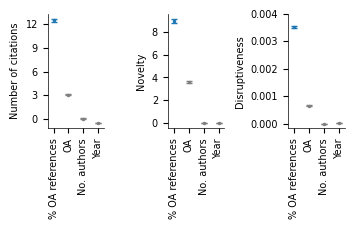

In [91]:
ax = plt.subplot(1, 3, 1)
drawCoefficientPlot(m3_res, ax)
ax.set_ylabel('Number of citations')
ax.set_yticks([0, 3, 6, 9, 12])

ax = plt.subplot(1, 3, 2)
drawCoefficientPlot(m_novelty_res, ax)
ax.set_ylabel('Novelty')
ax.set_yticks([0, 2, 4, 6, 8])

ax = plt.subplot(1, 3, 3)
drawCoefficientPlot(m_disruption_res, ax)
ax.set_ylabel('Disruptiveness')
ax.set_yticks([0, 0.001, 0.002, 0.003, 0.004])

set_size(7*CM, 4.5*CM)

plt.tight_layout()

plt.savefig('../figures/Impact_novelty_disruptiveness_regression.pdf', bbox_inches = 'tight', pad_inches = 0)

### Regress on residuals

In [93]:
def getCurve(x, result):

    def getVal(key):
        
        if key in result.params:
            return result.params[key]
        else:
            return 0

    intercept, a, b, c = getVal('Intercept'), getVal('Percent_within'), getVal('Percent_within2'), getVal('Percent_within3')

    return intercept + a*x + b*x**2 + c*x**3

In [92]:
%%time
m = ols('CitationCount_within ~ Year + is_oa + AuthorCount + \
AuthorMaxH_Index + FirstAuthorH_Index + AuthorMaxAge + FirstAuthorAge + \
C(CountryControl)', data=toRegress).fit()

CPU times: user 5min 40s, sys: 19.9 s, total: 6min
Wall time: 6min 5s


In [94]:
%%time
toRegress = (
    toRegress.assign(Residuals= m.resid)

    .assign(Percent_within2=lambda df: df.Percent_within.apply(lambda x: x**2))
    .assign(Percent_within3=lambda df: df.Percent_within.apply(lambda x: x**3))
)

CPU times: user 37.7 s, sys: 6.27 s, total: 44 s
Wall time: 44.1 s


In [95]:
%%time
residual1 = ols('Residuals ~ Percent_within', data=toRegress).fit()
residual2 = ols('Residuals ~ Percent_within + Percent_within2', data=toRegress).fit()
residual3 = ols('Residuals ~ Percent_within + Percent_within2 + Percent_within3', data=toRegress).fit()

CPU times: user 32.6 s, sys: 4.56 s, total: 37.2 s
Wall time: 37.3 s


In [96]:
%%time
regionalMean = (
    paperPaywalledPercent.pipe(printShape)
    
    .merge(paperSubRegion, on='PaperID')
    .pipe(printShape)
    
    .groupby('ProcessedSubRegion').Percent_within.mean().reset_index()
    .pipe(printShape)
)

(78821844, 5)  
(54742136, 6)  
(14, 2)  
CPU times: user 10.2 s, sys: 1.86 s, total: 12.1 s
Wall time: 13 s


In [97]:
regionsToPlot = (
    regionalMean.sort_values(by=['Percent_within']).head(13)
    .query('ProcessedSubRegion != "Western Asia"')
    .query('ProcessedSubRegion != "Southern Asia"')
    .query('ProcessedSubRegion != "Eastern Europe"')
    .query('ProcessedSubRegion != "Western Europe"')
    .query('ProcessedSubRegion != "Southern Europe"')
    

    .reset_index(drop=True)
    .pipe(printShape)
)

(8, 2)  


In [99]:
from matplotlib.pyplot import cm

colors = cm.RdYlBu([0, 0.08, 0.16, 0.24, 0.32, 0.84, 0.92, 1])

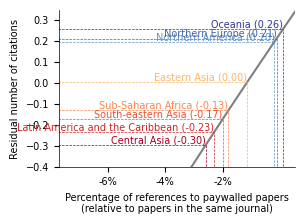

In [100]:
fig = plt.figure(figsize=(8.2*CM, 5*CM))
ax = plt.gca()

x = np.linspace(-1, 1, 1000)
ax.plot(x, getCurve(x, residual3), label='Quadratic', color='grey')

ax.set_xlabel('Percentage of references to paywalled papers\n(relative to papers in the same journal)')
ax.set_ylabel('Residual number of citations')

for ind, row in regionsToPlot.iterrows():

    percent = row['Percent_within']
    color = colors[ind]
    y = getCurve(percent, residual3)
    
    ax.plot([percent, percent], [-25, y], ls='--', color=color, lw=.5)
    ax.plot([-1, percent], [y, y], ls='--', color=color, lw=.5)
    ax.annotate(
        f'{row["ProcessedSubRegion"]} ({y:.2f})', (percent, y),
        color=color, horizontalalignment='right', verticalalignment='bottom'
    )

ax.set_xlim(-0.077, 0.005)
ax.set_ylim(-0.4, 0.35)

ax.set_xticks([-0.06, -0.04, -0.02])
ax.set_xticklabels(['-6%', '-4%', '-2%'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

set_size(6*CM, 4*CM, ax)
plt.savefig('../figures/Impact_paywalled_subregional_estimation.pdf', bbox_inches = 'tight', pad_inches = 0)